In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import numpy as np

Let's first look at the dataset description:

In [2]:
# Load the California Housing Prices dataset
california = fetch_california_housing(as_frame=True)
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [3]:
data = california.frame
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


This dataframe contains the 8 features in the first 8 columns while the last column corresponds to our target variable Median house value.

## Data Exploration

First, let's make sure we do not have missing values.

In [4]:
california.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


We can see that:

* the dataset contains 20,640 samples and 8 features;
* all features are numerical features encoded as floating number;
* there is no missing values.



Let's make a correlation heatmap to see which features vary the most with house price.

<Axes: >

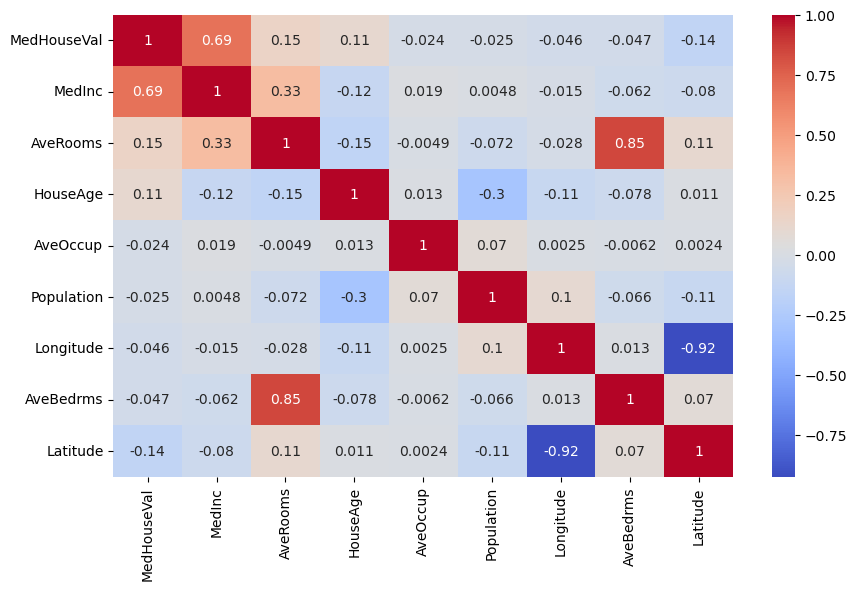

In [5]:
k = 9 #number of variables for heatmap
cols = data.corr().nlargest(k, 'MedHouseVal')['MedHouseVal'].index
cm = data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'coolwarm')



Let's have a quick look at the distributions:

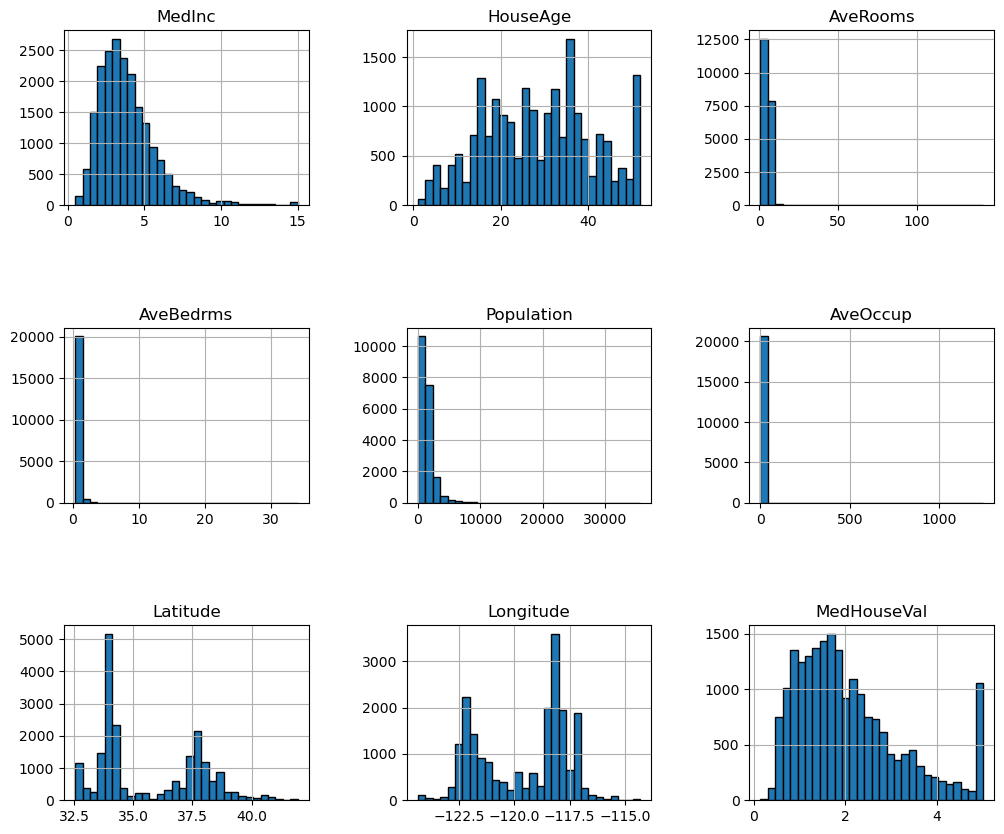

In [6]:
california.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Let's look at the feature where there seems to be outliers

anything over 500K is kept at 500K 

In [6]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
california.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000




We have ignore latitude/longitude until now but it could help us decide if there are locations associated with high-valued houses. In this case, we do need to consider them as a pair. To do so, we could make a scatter plot where the x- and y-axis would be the latitude and longitude and the circle size and color would be linked with the house value in the district.

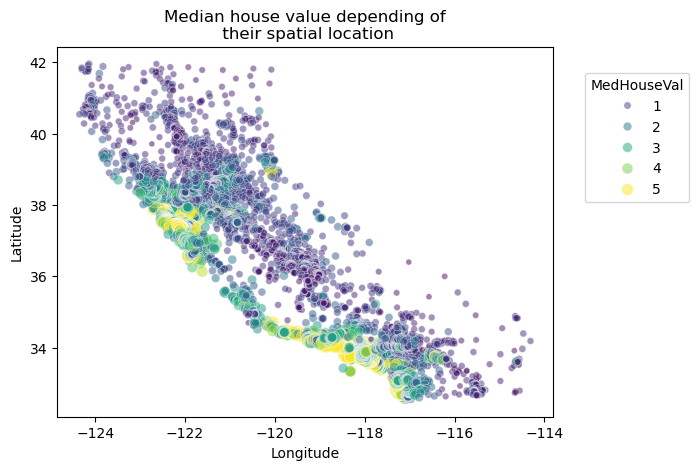

In [7]:
sns.scatterplot(
    data=california.frame,
    x="Longitude",
    y="Latitude",
    size="MedHouseVal",
    hue="MedHouseVal",
    palette="viridis",
    alpha=0.5,
)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")


## Building a regression model

Here, we will be using Ridge Regression, a type of linear regression which tends to be more robust for datasets in which there is correlation among the features.

Before running the model, we will be standardizing the values of the features by removing the mean and scaling to unit variance. This is important when the numerical values of each feature are vastly different from each other.

We will be using cross-validation to check the accuracy of our model. In this case, we choose the R2 metric to evaluate how well our model performs.

Let's also run this in parallel by using the parameter `njobs` to speed up the process

In [8]:
alphas = np.logspace(-3, 1, num=30)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
cv_results = cross_validate(
    model,
    california.data,
    california.target,
    return_estimator=True,
    n_jobs=2,
)

In [9]:
score = cv_results["test_score"]
print(f"R2 score: {score.mean():.3f} ± {score.std():.3f}")

R2 score: 0.553 ± 0.062


Let's have a look at the value of our coefficients:

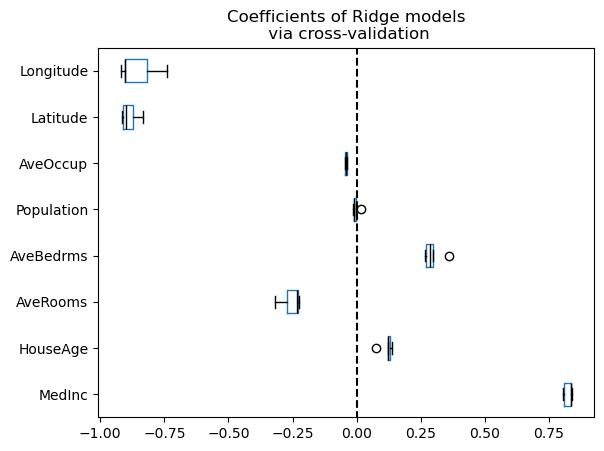

In [10]:
coefs = pd.DataFrame(
    [est[-1].coef_ for est in cv_results["estimator"]],
    columns=california.feature_names,
)
color = {"whiskers": "black", "medians": "black", "caps": "black"}
coefs.plot.box(vert=False, color=color)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
_ = plt.title("Coefficients of Ridge models\n via cross-validation")

## Reducing the number of features.

Since three of the features seem to be the most important, what would happen if we only build a model with these three (lat, lon and med income).

In [11]:
df = california.data[['MedInc','Latitude','Longitude']]
df

,MedInc,Latitude,Longitude
0,8.3252,37.88,-122.23
1,8.3014,37.86,-122.22
2,7.2574,37.85,-122.24
3,5.6431,37.85,-122.25
4,3.8462,37.85,-122.25
...,...,...,...
20635,1.5603,39.48,-121.09
20636,2.5568,39.49,-121.21
20637,1.7000,39.43,-121.22
20638,1.8672,39.43,-121.32


In [12]:
alphas = np.logspace(-3, 1, num=30)
model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
cv_results = cross_validate(
    model,
    df,
    california.target,
    return_estimator=True,
    n_jobs=2,
)

In [13]:
score = cv_results["test_score"]
print(f"R2 score: {score.mean():.3f} ± {score.std():.3f}")

R2 score: 0.533 ± 0.079


Our goodness of fit metrics hasn't significantly changed, suggesting that these three features may be enough.